1. Importaciones y configuración inicial

In [1]:
#Importante --->Importaciones de librerias
import sys
import os
import numpy as np
import pandas as pd
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from lecturaDatos import cargar_datos, visualizar_señal
from explora_metadatos import cargar_metadatos, analizar_metadatos, preparar_etiquetas, resumen_clases, filtrar_por_fold
from preprocessing import preprocesar_registro
from dataloaders import ECGDataGenerator
import tensorflow as tf
from prepare_dataset import crear_dataset_procesado
from model_cnn import crear_modelo

<Figure size 1200x400 with 0 Axes>

2. Carga y exploración de metadatos

In [2]:
# Cargar metadatos
df_meta ,df_scp = cargar_metadatos()
# 2. Explorar información básica
analizar_metadatos(df_meta)
# 3. Preparar etiquetas solo para CD ,STTC y Norm
clases_objetivo = {'CD', 'STTC', 'NORM'}
df_meta = preparar_etiquetas(df_meta, df_scp, nivel='diagnostic_class', clases_objetivo=clases_objetivo)
#Eiminamos los que no pertenecen a ninguna clase objetivo
df_meta = df_meta[df_meta['labels'].map(len) > 0]
 # 4. Mostrar distribución de clases
resumen_clases(df_meta)
# 5. Dividir en entrenamiento, validación y prueba
df_train, df_val, df_test = filtrar_por_fold(df_meta)
print(f"\nTamaño conjunto de entrenamiento: {len(df_train)}")
print(f"Tamaño conjunto de validación: {len(df_val)}")
print(f"Tamaño conjunto de prueba: {len(df_test)}")

Numero de registros: 21799

Columnas disponibles:
 ['ecg_id', 'patient_id', 'age', 'sex', 'height', 'weight', 'nurse', 'site', 'device', 'recording_date', 'report', 'scp_codes', 'heart_axis', 'infarction_stadium1', 'infarction_stadium2', 'validated_by', 'second_opinion', 'initial_autogenerated_report', 'validated_by_human', 'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems', 'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr']

Resumen de tipos de datos:
 ecg_id                            int64
patient_id                      float64
age                             float64
sex                               int64
height                          float64
weight                          float64
nurse                           float64
site                            float64
device                           object
recording_date                   object
report                           object
scp_codes                        object
heart_axis           

3.Preprocesamiento y guardado de señales

In [ ]:
from prepare_dataset import crear_dataset_procesado
crear_dataset_procesado(df_train, 'train', base_raw='../data/raw',out_dir='../data/processed')
crear_dataset_procesado(df_val, 'val', base_raw='../data/raw', out_dir='../data/processed')
crear_dataset_procesado(df_test, 'test', base_raw='../data/raw', out_dir='../data/processed')

4. Cargar datos procesados con generadores

In [3]:
from dataloaders import ECGDataGenerator

train_gen = ECGDataGenerator('../data/processed/train', batch_size=32)
val_gen   = ECGDataGenerator('../data/processed/val', batch_size=32, shuffle=False)

# Directorio de prueba (lo usaremos al final)
test_dir = '../data/processed/test'

# Confirmación rápida
print("Ejemplos entrenamiento:", len(train_gen))
print("Ejemplos validación:", len(val_gen))
print("Número de clases:", train_gen.n_classes)


Ejemplos entrenamiento: 453
Ejemplos validación: 58
Número de clases: 3


In [4]:
# Sanity check: obtener un batch y revisar formas
Xb, yb = train_gen[0]
print("Batch X shape:", Xb.shape)   # esperado: (batch_size, 5000, 12)
print("Batch y shape:", yb.shape)   # esperado: (batch_size, 3) para 3 clases
print("Ejemplo etiquetas (one-hot) del primer item:", yb[0])


Batch X shape: (32, 5000, 12)
Batch y shape: (32, 3)
Ejemplo etiquetas (one-hot) del primer item: [0. 1. 0.]


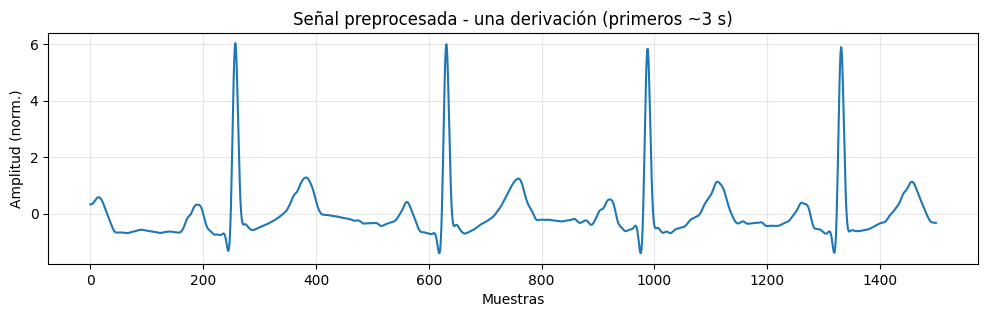

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,3))
plt.plot(Xb[0, :1500, 1])  # ~3 s si fs=500; derivación con índice 1
plt.title("Señal preprocesada - una derivación (primeros ~3 s)")
plt.xlabel("Muestras"); plt.ylabel("Amplitud (norm.)")
plt.grid(True, alpha=0.3)
plt.show()


Información del registro de ECG:
  - Frecuencia de muestreo: 500 Hz
  - Derivaciones disponibles: ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
  - Duración de la señal: 10.00 segundos

Visualizando la derivación 'II'...


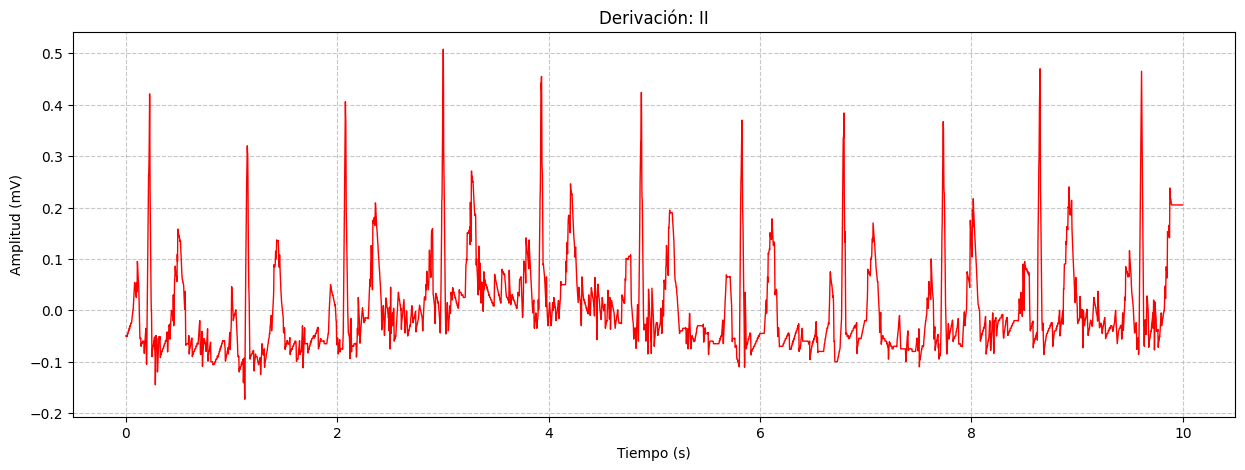

In [6]:

# Definimos la ruta a nuestros datos en crudo
# La ruta es relativa a la ubicación del notebook
#ruta_datos = '../data/raw/record_1.dat'
ruta_datos = '../data/raw/records500/00000/00001_hr'

# Cargamos los datos del ECG
registro_ecg = cargar_datos(ruta_datos)

# Mostramos información básica del registro
print("Información del registro de ECG:")
print(f"  - Frecuencia de muestreo: {registro_ecg.fs} Hz")
print(f"  - Derivaciones disponibles: {registro_ecg.sig_name}")
print(f"  - Duración de la señal: {len(registro_ecg.p_signal) / registro_ecg.fs:.2f} segundos")

# Visualizamos una de las derivaciones (por ejemplo, la segunda, con índice 1)
print("\nVisualizando la derivación 'II'...")
visualizar_señal(registro_ecg, derivacion_idx=1)

In [7]:
# Visualizacion de los Datos de la Matriz
# Importamos la librería pandas
import pandas as pd

# Creamos un DataFrame de Pandas a partir de la matriz de la señal
# Las columnas serán los nombres de las derivaciones
df = pd.DataFrame(registro_ecg.p_signal, columns=registro_ecg.sig_name)

# Mostramos las primeras 10 filas de la matriz
print("Mostrando las primeras 10 filas de la matriz de datos:")
df.head(100)

Mostrando las primeras 10 filas de la matriz de datos:


,I,II,III,AVR,AVL,AVF,V1,V2,V3,V4,V5,V6
0,-0.115,-0.050,0.065,0.082,-0.090,0.007,-0.065,-0.040,-0.005,-0.035,-0.035,-0.075
1,-0.115,-0.050,0.065,0.082,-0.090,0.007,-0.065,-0.040,-0.005,-0.035,-0.035,-0.075
2,-0.115,-0.050,0.065,0.082,-0.090,0.007,-0.065,-0.040,-0.005,-0.035,-0.035,-0.075
3,-0.115,-0.050,0.065,0.082,-0.090,0.007,-0.065,-0.040,-0.005,-0.035,-0.035,-0.075
4,-0.115,-0.050,0.065,0.082,-0.090,0.007,-0.065,-0.040,-0.005,-0.035,-0.035,-0.075
...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.145,-0.035,0.110,0.090,-0.127,0.037,-0.035,-0.025,-0.035,-0.025,-0.050,-0.080
96,-0.159,-0.049,0.110,0.104,-0.134,0.030,-0.022,-0.006,-0.035,-0.030,-0.051,-0.079
97,-0.185,-0.075,0.110,0.130,-0.147,0.017,-0.015,0.017,-0.033,-0.030,-0.046,-0.091
98,-0.214,-0.104,0.110,0.159,-0.162,0.003,-0.003,0.030,-0.040,-0.048,-0.063,-0.123


5. Definir y compilar el modelo

In [8]:
model = crear_modelo(input_shape=(5000, 12), n_classes=train_gen.n_classes)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',                 # multi-etiqueta
    metrics=['accuracy']
)
model.summary()

Model: "ecg_cnn_multilabel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5000, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 5000, 32)       │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 5000, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 5000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 5000, 64)       │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 5000, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 5000, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5000, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2500, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 2500, 64)       │        28,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2500, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 2500, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2500, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 2500, 128)      │        40,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2500, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 2500, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2500, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1250, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 1250, 128)      │        81,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1250, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 1250, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 308,483 (1.18 MB)

 Trainable params: 307,139 (1.17 MB)

 Non-trainable params: 1,344 (5.25 KB)

In [9]:
#Ponderar clases por desbalance

from ast import literal_eval

lbl_train = pd.read_csv('../data/processed/train/labels.csv')
clases = sorted({c for labs in lbl_train['labels'] for c in literal_eval(labs)})
class2idx = {c:i for i,c in enumerate(clases)}

# Conteos por clase
counts = np.zeros(len(clases), dtype=int)
for labs in lbl_train['labels']:
    for c in literal_eval(labs):
        counts[class2idx[c]] += 1

total = len(lbl_train)
# Pesos inversos (suavizados)
class_weights = {i: float(total / (len(clases) * max(1, counts[i]))) for i in range(len(clases))}
class_weights

{0: 1.2353894718880643, 1: 0.6354221520098298, 2: 1.1530498487020227}

In [10]:
# Vector de pesos por ejemplo (promedio de pesos de sus etiquetas)
sw = []
for labs in lbl_train['labels']:
    labs = literal_eval(labs)
    vals = [class_weights[class2idx[c]] for c in labs]
    sw.append(np.mean(vals) if vals else 1.0)
sample_weights_train = np.array(sw)

6. Entrenamiento


In [11]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint('../models/model_ecg_cnn.keras', save_best_only=True)  # ← .keras
    ],

)


Epoch 1/20
453/453 ━━━━━━━━━━━━━━━━━━━━ 236s 515ms/step - accuracy: 0.7870 - loss: 0.3312 - val_accuracy: 0.8212 - val_loss: 0.2977
Epoch 2/20
453/453 ━━━━━━━━━━━━━━━━━━━━ 251s 554ms/step - accuracy: 0.8170 - loss: 0.2908 - val_accuracy: 0.8075 - val_loss: 0.2729
Epoch 3/20
453/453 ━━━━━━━━━━━━━━━━━━━━ 238s 526ms/step - accuracy: 0.8219 - loss: 0.2825 - val_accuracy: 0.8256 - val_loss: 0.2712
Epoch 4/20
453/453 ━━━━━━━━━━━━━━━━━━━━ 234s 516ms/step - accuracy: 0.8272 - loss: 0.2741 - val_accuracy: 0.8196 - val_loss: 0.2935
Epoch 5/20
453/453 ━━━━━━━━━━━━━━━━━━━━ 227s 500ms/step - accuracy: 0.8296 - loss: 0.2705 - val_accuracy: 0.8382 - val_loss: 0.2568
Epoch 6/20
453/453 ━━━━━━━━━━━━━━━━━━━━ 227s 500ms/step - accuracy: 0.8311 - loss: 0.2698 - val_accuracy: 0.8414 - val_loss: 0.2533
Epoch 7/20
453/453 ━━━━━━━━━━━━━━━━━━━━ 239s 528ms/step - accuracy: 0.8344 - loss: 0.2622 - val_accuracy: 0.8349 - val_loss: 0.2878
Epoch 8/20
453/453 ━━━━━━━━━━━━━━━━━━━━ 254s 561ms/step - accuracy: 0.8357 -

7. Evaluación en el conjunto de prueba

Mejor época (por val_loss): 8


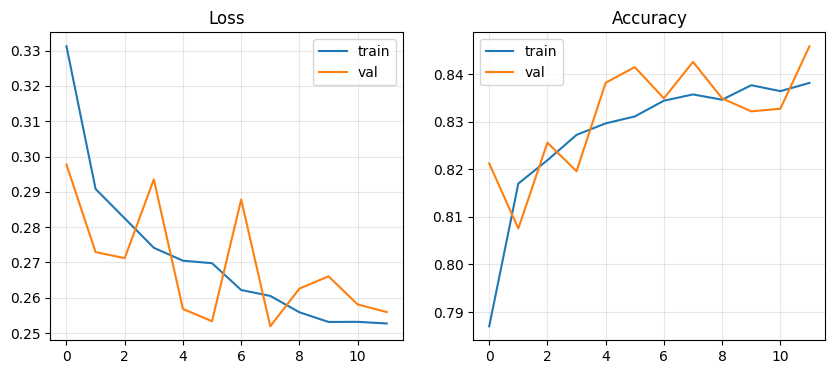

In [12]:
import matplotlib.pyplot as plt

best_epoch = int(np.argmin(history.history['val_loss'])) + 1
print(f"Mejor época (por val_loss): {best_epoch}")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss'); plt.legend(); plt.grid(alpha=.3)

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Accuracy'); plt.legend(); plt.grid(alpha=.3)
plt.show()


In [14]:
# Crear generador para el conjunto de prueba
from dataloaders import ECGDataGenerator

test_gen = ECGDataGenerator('../data/processed/test', batch_size=32, shuffle=False)

# Confirmar cuántos ejemplos tiene
print(f"Ejemplos en test: {len(test_gen)} batches (~{len(test_gen)*32} muestras)")


Ejemplos en test: 58 batches (~1856 muestras)


In [15]:
test_loss, test_acc = model.evaluate(test_gen, verbose=0)
print(f"Test - loss: {test_loss:.4f} | acc: {test_acc:.4f}")


Test - loss: 0.2657 | acc: 0.8327


In [16]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, classification_report
from ast import literal_eval

# nombres de clases desde tu generador
clases = sorted({c for labs in pd.read_csv('../data/processed/val/labels.csv')['labels']
                   for c in literal_eval(labs)})

y_true, y_pred = [], []
for i in range(len(test_gen)):
    Xb, yb = test_gen[i]
    pb = model.predict(Xb, verbose=0)
    y_true.append(yb)
    y_pred.append(pb)

y_true = np.vstack(y_true)
y_pred = np.vstack(y_pred)

# AUROC por clase
try:
    aurocs = roc_auc_score(y_true, y_pred, average=None)
    print("AUROC por clase:", dict(zip(clases, aurocs)))
except Exception as e:
    print("AUROC no disponible:", e)

# Umbral 0.5 para binarizar (ajustable)
y_hat = (y_pred >= 0.5).astype(int)
print(classification_report(y_true, y_hat, target_names=clases, zero_division=0))

AUROC por clase: {'CD': np.float64(0.9198766425477336), 'NORM': np.float64(0.9588660340208979), 'STTC': np.float64(0.950003521808801)}
              precision    recall  f1-score   support

          CD       0.84      0.73      0.78       496
        NORM       0.88      0.93      0.90       963
        STTC       0.85      0.79      0.82       521

   micro avg       0.87      0.84      0.85      1980
   macro avg       0.86      0.82      0.84      1980
weighted avg       0.87      0.84      0.85      1980
 samples avg       0.86      0.86      0.85      1980



In [18]:
import numpy as np
import pandas as pd
from ast import literal_eval

# Asegura que test_gen existe
# test_gen = ECGDataGenerator('../data/processed/test', batch_size=32, shuffle=False)

# Nombres de clases (en el mismo orden que usa el generador)
lbl_val = pd.read_csv('../data/processed/val/labels.csv')
clases = sorted({c for labs in lbl_val['labels'] for c in literal_eval(labs)})
print("Clases:", clases)

# Recolectar y_true / y_pred del conjunto de prueba
y_true, y_pred = [], []
for i in range(len(test_gen)):
    Xb, yb = test_gen[i]
    pb = model.predict(Xb, verbose=0)
    y_true.append(yb)
    y_pred.append(pb)

y_true = np.vstack(y_true)   # shape: (N, n_classes) -> one-hot multi-label
y_pred = np.vstack(y_pred)   # shape: (N, n_classes) -> probabilidades [0..1]
print(y_true.shape, y_pred.shape)


Clases: ['CD', 'NORM', 'STTC']
(1829, 3) (1829, 3)


In [19]:
# matris de confucion
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Etiquetas verdaderas y predichas como clase única (argmax)
y_true_argmax = y_true.argmax(axis=1)
y_pred_argmax = y_pred.argmax(axis=1)

# Matriz de confusión
cm = confusion_matrix(y_true_argmax, y_pred_argmax, labels=range(len(clases)))
cm


array([[326,  97,  73],
       [ 17, 854,  45],
       [ 22,  52, 343]])

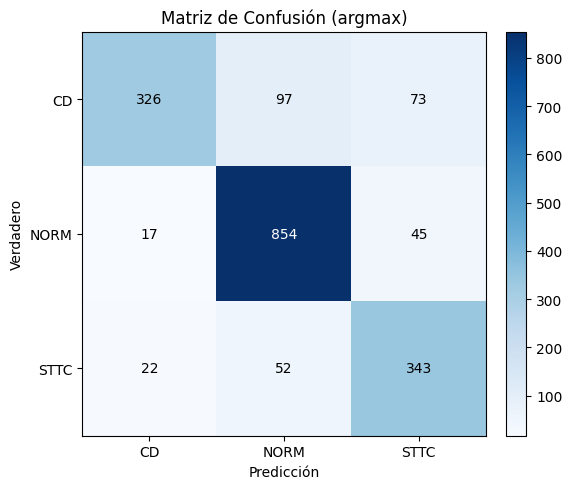

In [20]:
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(cm, cmap='Blues')

# Ticks y labels
ax.set_xticks(range(len(clases)))
ax.set_yticks(range(len(clases)))
ax.set_xticklabels(clases)
ax.set_yticklabels(clases)
ax.set_xlabel('Predicción')
ax.set_ylabel('Verdadero')
ax.set_title('Matriz de Confusión (argmax)')

# Números sobre cada celda
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha='center', va='center',
                color='white' if cm[i, j] > cm.max()*0.6 else 'black')

plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()


In [21]:
print(classification_report(y_true_argmax, y_pred_argmax, target_names=clases, digits=4))


              precision    recall  f1-score   support

          CD     0.8932    0.6573    0.7573       496
        NORM     0.8514    0.9323    0.8900       916
        STTC     0.7440    0.8225    0.7813       417

    accuracy                         0.8327      1829
   macro avg     0.8295    0.8040    0.8095      1829
weighted avg     0.8383    0.8327    0.8292      1829



In [22]:
from sklearn.metrics import roc_auc_score

try:
    aurocs = roc_auc_score(y_true, y_pred, average=None)
    print("AUROC por clase:")
    for c, a in zip(clases, aurocs):
        print(f"  {c}: {a:.4f}")
except Exception as e:
    print("No se pudo calcular AUROC:", e)


AUROC por clase:
  CD: 0.9199
  NORM: 0.9589
  STTC: 0.9500


In [23]:
import os

os.makedirs('../outputs/plots', exist_ok=True)
os.makedirs('../outputs/reports', exist_ok=True)

# Guardar la matriz como imagen
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(cm, cmap='Blues')
ax.set_xticks(range(len(clases)))
ax.set_yticks(range(len(clases)))
ax.set_xticklabels(clases); ax.set_yticklabels(clases)
ax.set_xlabel('Predicción'); ax.set_ylabel('Verdadero')
ax.set_title('Matriz de Confusión (argmax)')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha='center', va='center',
                color='white' if cm[i, j] > cm.max()*0.6 else 'black')
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.savefig('../outputs/plots/confusion_matrix.png', dpi=150)
plt.close()

# Guardar reporte de clasificación a texto
rep_text = classification_report(y_true_argmax, y_pred_argmax, target_names=clases, digits=4)
with open('../outputs/reports/classification_report.txt', 'w', encoding='utf-8') as f:
    f.write(rep_text)

print("Guardados: outputs/plots/confusion_matrix.png y outputs/reports/classification_report.txt")


Guardados: outputs/plots/confusion_matrix.png y outputs/reports/classification_report.txt


8.Guardado y carga del modelo

In [17]:
model.save('../models/model_ecg_cnn.keras')